# Sowing Success: How Machine Learning Helps Farmers Select the Best Crops



Measuring essential soil metrics such as nitrogen, phosphorous, potassium levels, and pH value is an important aspect of assessing soil condition. However, it can be an expensive and time-consuming process, which can cause farmers to prioritize which metrics to measure based on their budget constraints.

Farmers have various options when it comes to deciding which crop to plant each season. Their primary objective is to maximize the yield of their crops, taking into account different factors. One crucial factor that affects crop growth is the condition of the soil in the field, which can be assessed by measuring basic elements such as nitrogen and potassium levels. Each crop has an ideal soil condition that ensures optimal growth and maximum yield.

A farmer reached out to you as a machine learning expert for assistance in selecting the best crop for his field. They've provided you with a dataset called `soil_measures.csv`, which contains:

- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"pH"` value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

Each row in this dataset represents various measures of the soil in a particular field. Based on these measurements, the crop specified in the `"crop"` column is the optimal choice for that field.  

In this project, you will build multi-class classification models to predict the type of `"crop"` and identify the single most importance feature for predictive performance.

CHECK for null values in dataset:
N       0
P       0
K       0
ph      0
crop    0
dtype: int64
==> no null values in dataset, proceed without additional preprocessing (cleaning, imputing)

CHECK for need to scale:
             N        P        K       ph
count  2200.00  2200.00  2200.00  2200.00
mean     50.55    53.36    48.15     6.47
std      36.92    32.99    50.65     0.77
min       0.00     5.00     5.00     3.50
25%      21.00    28.00    20.00     5.97
50%      37.00    51.00    32.00     6.43
75%      84.25    68.00    49.00     6.92
max     140.00   145.00   205.00     9.94
==> values are not scattered in any extreme way, so no scaling necessary



RESULTS

Version 1: without k-Fold Cross-Validation
Feature: N | Accuracy: 0.15
Feature: P | Accuracy: 0.19
Feature: K | Accuracy: 0.27
Feature: ph | Accuracy: 0.11

Single best predictive feature (based on accuracy): {'K': 0.26666666666666666}

Version 2: with k-Fold Cross-Validation (mean values over all folds)
Feature: N | Ac

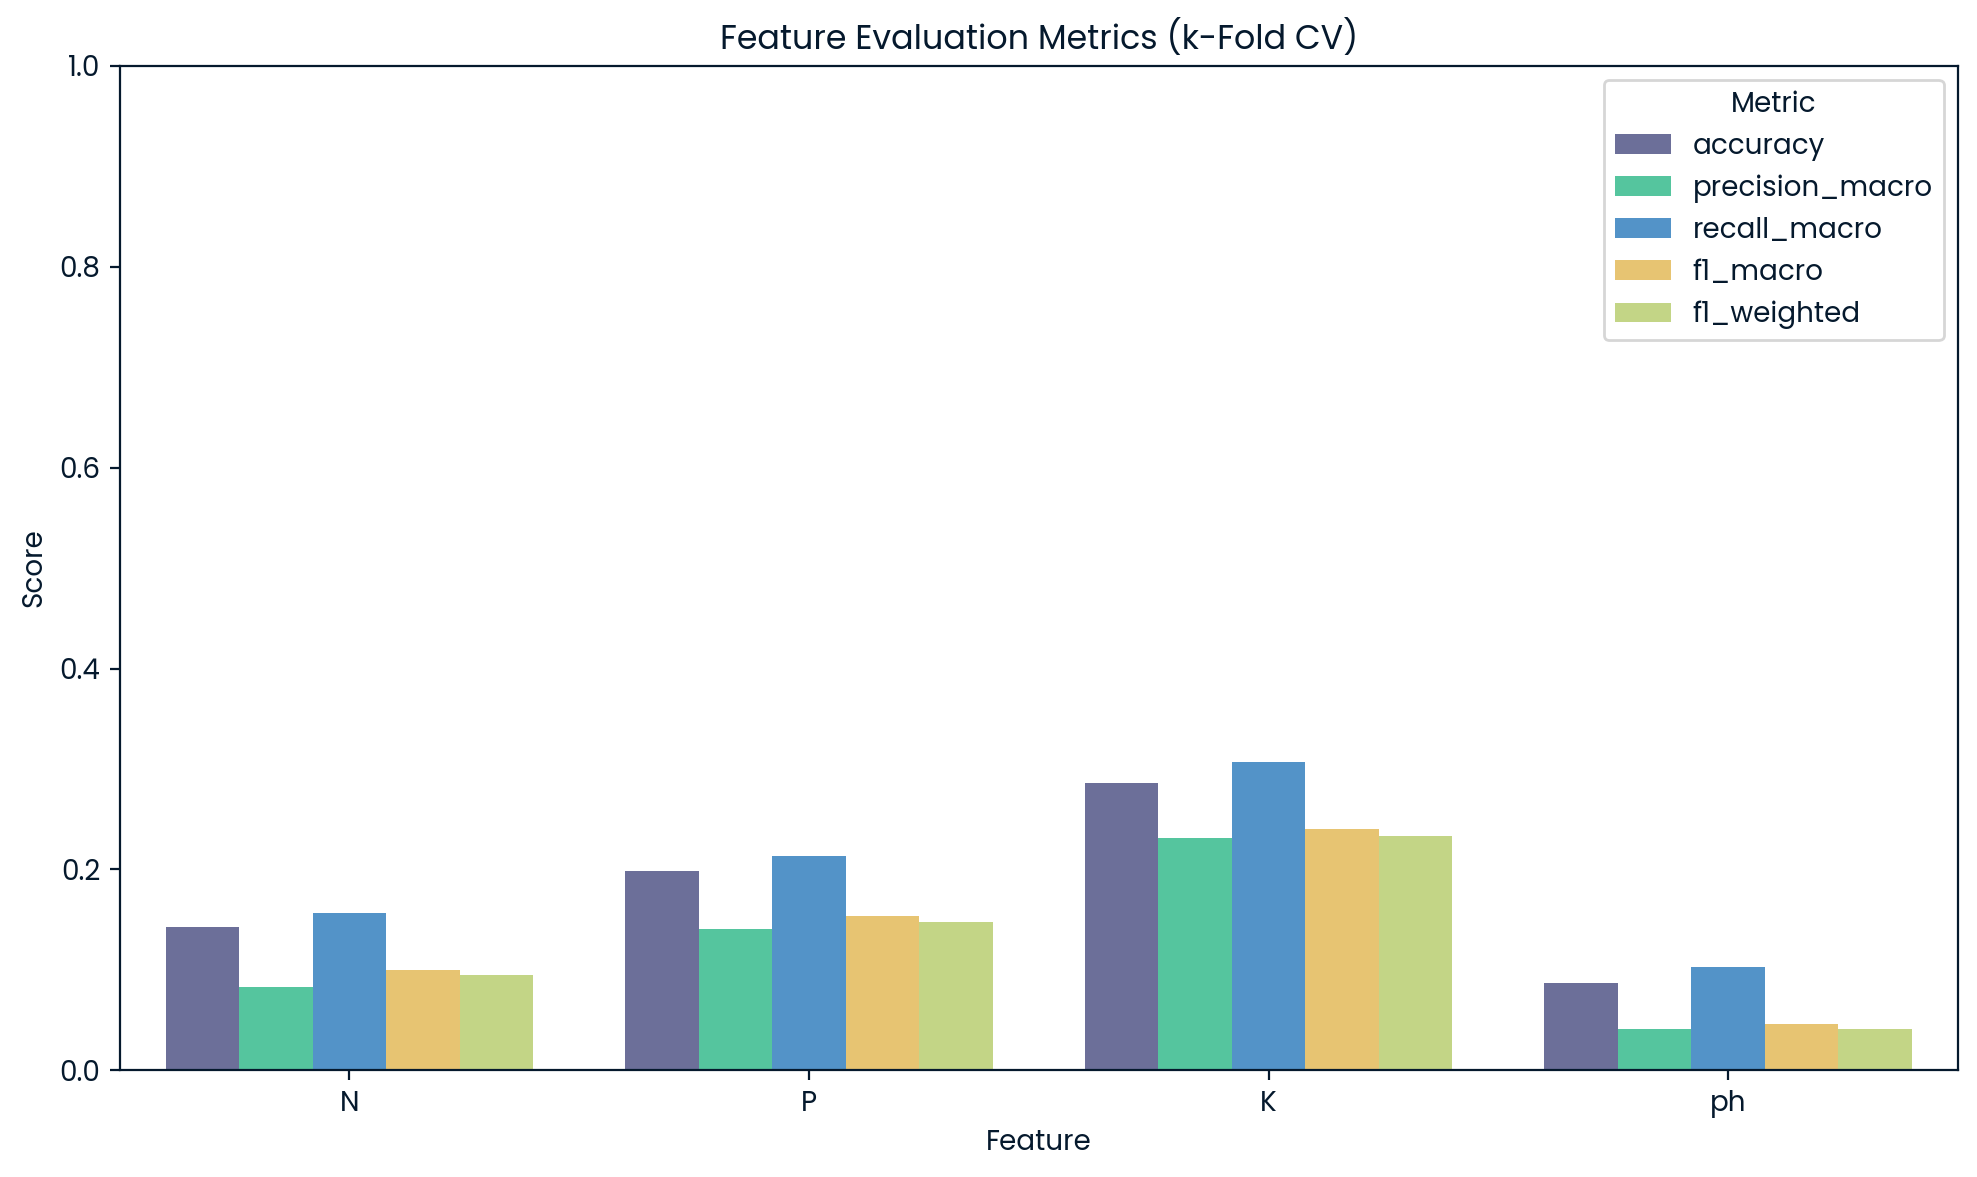

In [11]:
# All required libraries are imported here for you.
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn import metrics
from sklearn.metrics import confusion_matrix  # Import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
crops = pd.read_csv("soil_measures.csv")

# CHECK for null values:
print("CHECK for null values in dataset:")
print(crops.isnull().sum())
print("==> no null values in dataset, proceed without additional preprocessing (cleaning, imputing)")

# CHECK for necessity of scaling
print("\nCHECK for need to scale:")
print(crops.describe().round(2))
print("==> values are not scattered in any extreme way, so no scaling necessary")

# Split the dataset
X = crops.drop(columns=["crop"])
y = crops["crop"]
# don't need test-train split if kFold CV is being used
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Extract features (X column names), create dictionary and initialize k-Fold object for best predictive features
feature_names = X.columns.tolist()
best_predictive_features = best_predictive_features_kfCV = {} # for single evaluation as well as k-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)


# RESULTS
"""
Initialize the ML model with multi-classification argument for each feature in X
Task: predict category of crop: categorical problem 
==> use categorical model such as Decision Tree, Random Forest, kNN, Logistic Regression,...
no pipeline necessary for lack of preprocessing 
"""

print("")
print(50*"=")
print("\n\nRESULTS\n")

# Version 1 without kFold Cross-Validation
"""
We can't use classification_report(y_test, y_pred) here for easy calculation of all metrics with one function. This is because it calculates the metrics for each >class<, i.e. each unique target value of the target column ("crop") - in other words "how well each model predicts each class". However, here, we want to evaluate each feature's predictive performance, i.e. how well a model, that has been trained on a single feature, can predict the target values/classes ("crop").
"""

print("Version 1: without k-Fold Cross-Validation")

for feature in feature_names:
    logreg = LogisticRegression(multi_class="multinomial", max_iter=1000)
    logreg.fit(X_train[[feature]], y_train)
    
    # predict classes using the test set
    y_pred = logreg.predict(X_test[[feature]])
    
    # evaluate feature performances
    best_predictive_features[feature] = metrics.accuracy_score(y_test, y_pred, normalize=True)
    print(f"Feature: {feature} | Accuracy: {best_predictive_features[feature]:.2f}")

# Extract the best feature based on the highest accuracy score for project submission
"""
max() iterates over all keys in the dictionary: 'N', 'P', 'K', 'ph'.
The 'key' parameter allows to provide a function that tells max() how to evaluate each element. For each key, it calls best_predictive_features.get(key) to return the associated value, i.e. the accuracy.
It then compares these values and selects the key with the highest value.
"""
best_feature = max(best_predictive_features, key=best_predictive_features.get)
best_predictive_feature = {best_feature: best_predictive_features[best_feature]}
print("\nSingle best predictive feature (based on accuracy):", best_predictive_feature)


# Version 2 with k-Fold Cross-Validation
print("\nVersion 2: with k-Fold Cross-Validation (mean values over all folds)")

# Comments about used metrics
"""
# In macro metrics, every class contributes equally to the final score, regardless of its frequency in the dataset. This ensures that all classes are considered equally important, so a feature that helps predict rare crops is not overlooked.
# Accuracy measures the percentage of correct predictions. If the classes (here: crop types) are relatively balanced, accuracy is a quick and intuitive measure for each feature's performance.
# Precision (macro) is calculated by computing the precision for each class separately and then taking the mean of these precision scores. Each class' precision is the ratio of true positives to the sum of true positives and false positives. The macro average treats each class equally, ensuring that performance on rare classes is given the same weight as on common classes.
# Recall (macro) is computed by calculating the recall for each class individually and then taking the arithmetic mean of these recall values.
# Recall (macro) is computed by calculating the recall for each class individually and then taking the arithmetic mean of these recall values. Each class' recall is the ratio of true positives to the sum of true positives and false negatives. By averaging these values equally, the macro recall reflects how well the model captures all positive instances across all classes, regardless of class frequency.
# F1 (macro) calculates the harmonic mean of precision and recall for each class individually and then averages them equally and unweighted. 
# F1 (weighted) is similar to the F1 (macro) score, but each class' F1 score is weighted by the number of true instances/values in that class. Classes with more instances have a higher impact on the final score. This is useful when the classes are imbalanced as it gives more importance to the performance of common classes, providing an overall metric that reflects the distribution of the dataset.
"""

scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',  # macro for unweighted average in multi-class problems
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro',
    'f1_weighted': 'f1_weighted'
}

for feature in feature_names:
    cv_results = cross_validate(
        LogisticRegression(multi_class="multinomial", max_iter=1000), 
        X[[feature]], 
        y, 
        cv=kf, 
        scoring=scoring, 
        n_jobs=-1 # use all CPU cores for faster processing
    )
    # Average each split's metric for each feature
    best_predictive_features_kfCV[feature] = {
        'accuracy': np.mean(cv_results['test_accuracy']),
        'precision_macro': np.mean(cv_results['test_precision_macro']),
        'recall_macro': np.mean(cv_results['test_recall_macro']),
        'f1_macro': np.mean(cv_results['test_f1_macro']),
        'f1_weighted': np.mean(cv_results['test_f1_weighted'])
    }
    
    print(f"Feature: {feature} | Accuracy: {best_predictive_features_kfCV[feature]['accuracy']:.2f}, Precision: {best_predictive_features_kfCV[feature]['precision_macro']:.2f}, Recall: {best_predictive_features_kfCV[feature]['recall_macro']:.2f}, F1 (macro): {best_predictive_features_kfCV[feature]['f1_macro']:.2f}, F1 (weighted): {best_predictive_features_kfCV[feature]['f1_weighted']:.2f}")
    
# INTERPRETATION
print("\nINTERPRETATION\n")
print("The evaluation of the model's metrics shows that the content ratio in soil for POTASSIUM K is the strongest single predictor for crop. \n\nHowever, with a mean accuracy around 29% and slightly higher precision, recall, and F1 scores compared to the other features, these values are still very low overall. This indicates that using any one soil measurement by itself doesn't provide a strong basis for accurately predicting the best crop.\n\nTo build a more robust model, all features (elements in soil) should be included in training which would be the next step to improve this model.")


# VISUALIZATION 
# Convert dictionary to a DataFrame for plotting where each row corresponds to a feature and each column to a metric.
df_best_predictive_features_kfCV = pd.DataFrame.from_dict(best_predictive_features_kfCV, orient='index')
df_best_predictive_features_kfCV = df_best_predictive_features_kfCV.reset_index().rename(columns={'index': 'feature'})

# Melt the DataFrame to a long format for seaborn plotting with the features on the x-axis and scores on the y-axis. For example, imagine the DataFrame has two columns, A and B. Instead of:
#   A: 1, 2    B: 3, 4
# It “stacks” them into the two columns "variable" and "value":
#   variable: A, B, A, B
#   value:    1, 3, 2, 4
df_best_predictive_features_kfCV_melted = df_best_predictive_features_kfCV.melt(id_vars='feature', var_name='metric', value_name='score')

# Create a grouped bar plot to compare the metrics (accuracy, precision_macro, recall_macro, f1_macro, f1_weighted) for each feature.
plt.figure(figsize=(10, 6))
sns.barplot(data=df_best_predictive_features_kfCV_melted, x='feature', y='score', hue='metric')
plt.title('Feature Evaluation Metrics (k-Fold CV)')
plt.xlabel('Feature')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Metric', bbox_to_anchor=(1, 1), loc='best')
plt.tight_layout()
plt.show()